##ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

import dct

%matplotlib inline

**Exercise:** In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [2]:
signal = thinkdsp.UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

In [3]:
ns = 2 ** np.arange(6, 15)
ns

array([   64,   128,   256,   512,  1024,  2048,  4096,  8192, 16384])

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [4]:
def plot_bests(bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = scipy.stats.linregress(x,y)
    slope = t[0]

    return slope

Here are the results for `analyze1`.

64
The slowest run took 20.00 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 215 µs per loop
128
The slowest run took 29.29 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 807 µs per loop
256
100 loops, best of 1: 2.89 ms per loop
512
100 loops, best of 1: 13.1 ms per loop
1024
10 loops, best of 1: 79.2 ms per loop
2048
1 loops, best of 1: 380 ms per loop
4096
1 loops, best of 1: 1.87 s per loop
8192
1 loops, best of 1: 8.21 s per loop
16384
1 loops, best of 1: 1min 5s per loop


2.2729126725573052

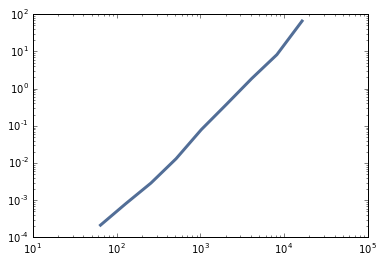

In [5]:
results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]
plot_bests(bests)

The estimated slope is close to 2, not 3, as expected.  One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

The line is curved, which suggests that we have not reached the array size where the runtime shows cubic growth.  With larger array sizes, the estimated slope increases, so maybe it eventually converges on 3.

Here are the results for `analyze2`:

1000 loops, best of 1: 143 µs per loop
1000 loops, best of 1: 565 µs per loop
100 loops, best of 1: 2.22 ms per loop
100 loops, best of 1: 9.16 ms per loop
10 loops, best of 1: 38.8 ms per loop
10 loops, best of 1: 144 ms per loop
1 loops, best of 1: 588 ms per loop
1 loops, best of 1: 2.35 s per loop
1 loops, best of 1: 12.7 s per loop


2.0312154911232745

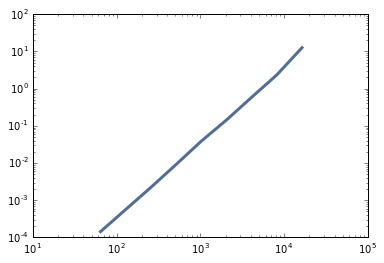

In [6]:
results = []
for N in ns:
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze2(ys, freqs, ts)
    results.append(result)

bests2 = [result.best for result in results]
plot_bests(bests2)

The results for `analyze2` fall in a straight line with the estimated slope close to 2, as expected.

Here are the results for the `scipy.fftpack.dct`

The slowest run took 12267.38 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 8.11 µs per loop
100000 loops, best of 3: 8.75 µs per loop
The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 9.42 µs per loop
The slowest run took 5.12 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.3 µs per loop
The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 15 µs per loop
The slowest run took 4.72 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 23.8 µs per loop
The slowest run took 4.62 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 41.7 µs per loo

0.55556666552707867

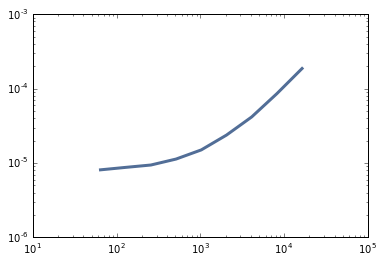

In [7]:
results = []
for N in ns:
    ys = noise.ys[:N]
    result = %timeit -o scipy.fftpack.dct(ys, type=3)
    results.append(result)

bests3 = [result.best for result in results]
plot_bests(bests3)

This implementation of dct is even faster.  The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.  In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

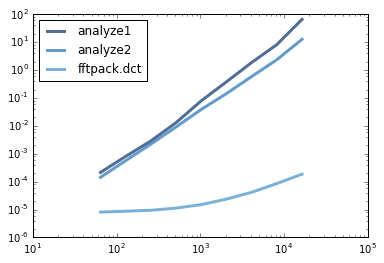

In [8]:
thinkplot.preplot(3)
thinkplot.plot(ns, bests, label='analyze1')
thinkplot.plot(ns, bests2, label='analyze2')
thinkplot.plot(ns, bests3, label='fftpack.dct')
thinkplot.config(xscale='log', yscale='log', legend=True, loc='upper left')

**Exercise:** One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [2]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [3]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

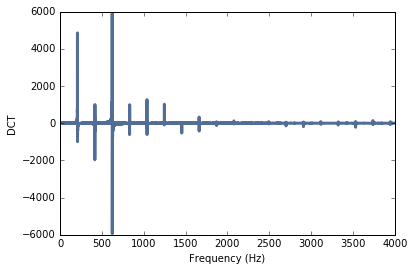

In [4]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [5]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

20457	22050	92.77551020408163


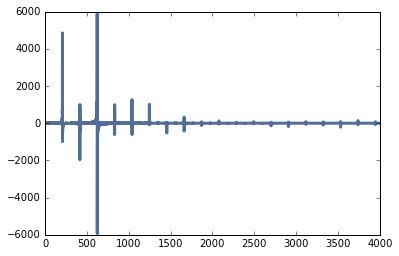

In [6]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

And the result sounds the same (at least to me):

In [7]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [8]:
def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return thinkdsp.Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [9]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

In most segments, the compression is 75-80%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [10]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [11]:
wave.make_audio()

As an experiment, you might try increasing `thresh` to see when the effect of compression becomes audible (to you).

Also, you might try compressing a signal with some noisy elements, like cymbals.